Experiment 3: FIFA 20 Dataset from Kaggle

In [34]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
sns.set_theme()

# sklearn
from sklearn.ensemble import RandomForestClassifier 
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# pytorch
import torch
from torch.optim import Adam
from torch import nn

# BERT from Huggingface
from transformers import BertTokenizer
from transformers import BertModel

# Dataset class

# Extra additional packages/functions
from balancers import BinaryBalancer
from utils import calculate_bias_metrics, eo_postprocess, calc_gen_bounds

In [35]:
# Import fifa 20 dataset
all_data = pd.read_csv('players_20.csv')
all_data.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,32,1987-06-24,170,72,Argentina,FC Barcelona,...,68+2,66+2,66+2,66+2,68+2,63+2,52+2,52+2,52+2,63+2
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,34,1985-02-05,187,83,Portugal,Juventus,...,65+3,61+3,61+3,61+3,65+3,61+3,53+3,53+3,53+3,61+3
2,190871,https://sofifa.com/player/190871/neymar-da-sil...,Neymar Jr,Neymar da Silva Santos Junior,27,1992-02-05,175,68,Brazil,Paris Saint-Germain,...,66+3,61+3,61+3,61+3,66+3,61+3,46+3,46+3,46+3,61+3
3,200389,https://sofifa.com/player/200389/jan-oblak/20/...,J. Oblak,Jan Oblak,26,1993-01-07,188,87,Slovenia,Atlético Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,183277,https://sofifa.com/player/183277/eden-hazard/2...,E. Hazard,Eden Hazard,28,1991-01-07,175,74,Belgium,Real Madrid,...,66+3,63+3,63+3,63+3,66+3,61+3,49+3,49+3,49+3,61+3


In [38]:
# Process data for later use

# Keep relevant columns
o_data = all_data[['long_name','age','nationality','overall','wage_eur']].copy(deep = True)

# Change column names of nationality and wage_eur to a and y 
o_data.rename(columns = {'nationality':'a', 'wage_eur':'y'}, inplace = True)

# Restrict to Argentina and English nationality
o_data = o_data.loc[(o_data['a'].isin(['Brazil', 'England']))]
print('Number of players:', o_data.shape[0])

# Only keep relevant feagires and outcomes
data = o_data[['long_name','age','a','overall','y']].copy(deep = True)

# Binarize nationality
# 0 = Germany and 1 = England
data = data.replace('Brazil',0)
data = data.replace('England',1)

# Reset the index
data = data.reset_index(drop=True)

# Binarize outcome using median outcome
data.loc[data['y'] < np.median(data['y']), 'y'] = 0
data.loc[data['y'] >= np.median(data['y']), 'y'] = 1
data.head()

Number of players: 2491


,long_name,age,a,overall,y
0,Neymar da Silva Santos Junior,27,0,92,1
1,Harry Kane,25,1,89,1
2,Alisson Ramses Becker,26,0,89,1
3,Ederson Santana de Moraes,25,0,88,1
4,Raheem Sterling,24,1,88,1


In [39]:
# Create new column to stratify data and calculate base rates
group = []
for i in range(data.shape[0]):
    # w
    if np.sum(data[['a','y']].iloc[i] == [0,0]) == 2:
        group.append(1)
    # v
    if np.sum(data[['a','y']].iloc[i] == [1,0]) == 2:
        group.append(2)
    # s
    if np.sum(data[['a','y']].iloc[i] == [0,1]) == 2:
        group.append(3)
    # r
    if np.sum(data[['a','y']].iloc[i] == [1,1]) == 2:
        group.append(4)

# Add column to the data
data['group'] = group

# Calculate base rates
total = data.shape[0]
r = np.sum(data['group'] == 4)/total
s = np.sum(data['group'] == 3)/total
v = np.sum(data['group'] == 2)/total
w= np.sum(data['group'] == 1)/total
print('min rate = ', min(r,s,w,v))

min rate =  0.0718586912886391


In [40]:
# Classes to use BERT

# Using Bert for text classification
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Dataset class for BERT
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [label for label in df['a']]
        self.texts = [tokenizer(text, 
                               padding='max_length', max_length = 5, truncation=True,
                                return_tensors="pt") for text in df['long_name']]
        self.remain_data = [df[['age','overall','y','group']].iloc[idx] for idx in range(df.shape[0])]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        batch_texts = self.texts[idx]
        batch_y = torch.tensor(self.labels[idx])
        batch_rest = torch.tensor(self.remain_data[idx])

        return batch_texts, batch_y, batch_rest

# Class for classifier
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.sigmoid(linear_output)

        return final_layer

In [41]:
# Function to train model
batch_sz = 2

def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_sz, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=batch_sz)

    # use_cuda = torch.cuda.is_available()
    # device = torch.device("cuda" if use_cuda else "cpu")
    device = torch.device("mps")
    model.to(device)

    criterion = nn.BCELoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)


    for epoch_num in range(epochs):

        model.train()
        total_loss_train = 0
        total_tp_train = 0

        for train_input, train_label, _ in tqdm(train_dataloader):

            train_label = train_label.to(device).float()
            mask = train_input['attention_mask'].to(device)
            input_id = train_input['input_ids'].squeeze(1).to(device)

            output = model(input_id, mask).reshape(1,-1)[0] 
            batch_loss = criterion(output, train_label)
            batch_tp = torch.sum((output >= 0.5) == train_label)
            
            total_tp_train += batch_tp.item()
            total_loss_train += batch_loss.item()

            model.zero_grad()
            batch_loss.backward()
            optimizer.step()
                
        total_loss_val = 0
        total_tp_val = 0

        with torch.no_grad():

            model.eval()

            for val_input, val_label, _ in val_dataloader:

                val_label = val_label.to(device).float()
                mask = val_input['attention_mask'].to(device)
                input_id = val_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask).reshape(1,-1)[0]
                batch_loss = criterion(output, val_label)
                batch_tp = torch.sum((output >= 0.5) == val_label)
                    
                total_tp_val += batch_tp.item()    
                total_loss_val += batch_loss.item()
                    
            
        print(
            f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / (len(train_data)/batch_sz): .3f} \
            | Train Accuracy: {total_tp_train / len(train_data): .3f} \
            | Val Loss: {total_loss_val / (len(val_data)/batch_sz): .3f} \
            | Val Accuracy: {total_tp_val / len(val_data): .3f}')

In [42]:
# Experiment Parameters
EPOCHS = 7
model = BertClassifier()
LR = 1e-6 

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
# Splitting data into necessary datasets
d_xa, d_remain = train_test_split(data, train_size = 0.6, stratify=data['group'])

In [44]:
# Split d_xa into d_xa_train and d_xa_val
d_xa_train, d_xa_val = train_test_split(d_xa, train_size = 0.8, stratify=d_xa['group'])

# Train model
train(model, d_xa_train, d_xa_val, LR, EPOCHS)

 12%|█▏        | 73/598 [00:30<03:42,  2.36it/s]


KeyboardInterrupt: 

Enforcing fairness

In [143]:
# Will repeatedly split data into
# d_xy_train
# d_xy_test
# d_xy_tune

bias_t_o = []
bias_f_o = []
bias_t_n = []
bias_f_n = []
u_bound_t_o = []
l_bound_t_o = []
u_bound_f_o = []
l_bound_f_o = []
u_bound_t_n = []
l_bound_t_n = []
u_bound_f_n = []
l_bound_f_n = []

for i in range(500):
    d_xy_train, d_xy_remain = train_test_split(d_remain, train_size = 0.75, stratify=d_remain['group'])
    d_xy_test, d_xay = train_test_split(d_xy_remain, train_size = 0.5, stratify=d_xy_remain['group'])

    # Create Classifier
    clf = RandomForestClassifier(n_estimators=50)

    # Split data into features and labels
    x_train = d_xy_train[['age','overall']]
    y_train = d_xy_train['wage_eur']
    x_test = d_xy_test[['age','overall']]
    y_test = d_xy_test['wage_eur']

    # Fit classifier
    clf.fit(x_train.to_numpy(),y_train)

    # Model Accuracy:
    # print("Accuracy:", metrics.accuracy_score(y_test, clf.predict(x_test.to_numpy())))

    # Evaluate probabilities/y_hat on test set
    y_prob = clf.predict_proba(x_test.to_numpy())
    
    # Add y_prob/y_hat to data
    d_xy_test['y_prob'] = y_prob[:,1]
    d_xy_test['y_hat'] = (y_prob[:,1] >= 0.5)

    # Calculate bias metrics with respect to a
    alpha, beta, tau, phi = calculate_bias_metrics(d_xy_test)
    bias_t_o.append(alpha - beta)
    bias_f_o.append(tau - phi)

    # Calculating a_hat using the trained BERT model
    xy_test = Dataset(d_xy_test)
    xy_test_dataloader = torch.utils.data.DataLoader(xy_test, batch_size=len(xy_test))
    device = torch.device("cpu")
    model.to(device)
    model = model.eval()
    with torch.no_grad():
        for xy_test_input, xy_test_label, xy_test_remain in xy_test_dataloader:
            xy_test_label = xy_test_label.to(device).float()
            mask = xy_test_input['attention_mask'].to(device)
            input_id = xy_test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask).reshape(1,-1)[0]
    
    # Replace a column with a_hat to data
    a_true = d_xy_test['a']
    d_xy_test['a'] = (output >= 0.5)
    a_error = np.sum(d_xy_test['a'] != d_xy_test['nationality'])/d_xy_test.shape[0]

    # Computing upper and lower bounds
    alpha_hat, beta_hat, tau_hat, phi_hat = calculate_bias_metrics(d_xy_test)
    ub_t_o, lb_t_o = calc_gen_bounds(alpha_hat,beta_hat,a_error,r,s)
    ub_f_o, lb_f_o = calc_gen_bounds(tau_hat,phi_hat,a_error,v,w)
    u_bound_t_o.append(ub_t_o)
    l_bound_t_o.append(lb_t_o)
    u_bound_f_o.append(ub_f_o)
    l_bound_f_o.append(lb_f_o)

    # Using d_xay to learn a fair f wrt to a_hat

    # Evaluate probabilities/y_hat on d_xay set
    y_prob = clf.predict_proba(d_xay[['age','overall']].to_numpy())
    
    # Add y_prob/y_hat to data
    d_xay['y_prob'] = y_prob[:,1]
    d_xay['y_hat'] = (y_prob[:,1] >= 0.5)

    # Calculating a_hat using the trained BERT model
    xay = Dataset(d_xay)
    xay_dataloader = torch.utils.data.DataLoader(xay, batch_size=len(xay))
    device = torch.device("cpu")
    model.to(device)
    model = model.eval()
    with torch.no_grad():
        for xay_input, xay_label, xay_remain in xay_dataloader:
            xay_label = xay_label.to(device).float()
            mask = xay_input['attention_mask'].to(device)
            input_id = xay_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask).reshape(1,-1)[0]

    # Replace a column with a_hat to data
    d_xay['a'] = np.array((output >= 0.5)).astype('float')
    # a_error = np.sum(d_xy_test['a'] != d_xy_test['nationality'])/d_xy_test.shape[0]

    # Learn fair f
    _, fair_model = eo_postprocess(d_xay)

    # Calculate new bias_estimates
    df_ah_fair = d_xy_test.copy(deep = True)
    df_ah_fair.y_hat = fair_model.predict(d_xy_test.y_prob.values,d_xy_test.a.values)

    # Calculate est bias_tpr and bias_fpr
    alpha_hat_f, beta_hat_f, tau_hat_f, phi_hat_f = calculate_bias_metrics(df_ah_fair)

    # Computing the new upper bound and lower bounds under the assumption
    ub_t_n, lb_t_n = calc_gen_bounds(alpha_hat_f,beta_hat_f,a_error,r,s)
    ub_f_n, lb_f_n = calc_gen_bounds(tau_hat_f,phi_hat_f,a_error,v,w)
    l_bound_t_n.append(lb_t_n)
    l_bound_f_n.append(lb_f_n)
    u_bound_t_n.append(ub_t_n)
    u_bound_f_n.append(ub_f_n)

    # Calculate new true bias wrt to a with fair f
    d_xy_test['a'] = a_true
    yh_fair = fair_model.predict(d_xy_test.y_prob.values,d_xy_test.a.values)
    df_fair = d_xy_test.copy(deep=True)
    df_fair.y_hat = yh_fair
    alpha_n, beta_n, tau_n, phi_n = calculate_bias_metrics(df_fair)

    # New bias
    bias_t_n.append(alpha_n - beta_n)
    bias_f_n.append(tau_n - phi_n)

# Computing max distributions
max_t_o = np.maximum(np.abs(u_bound_t_o),np.abs(l_bound_t_o))
max_t_n = np.maximum(np.abs(u_bound_t_n),np.abs(l_bound_t_n))
max_f_o = np.maximum(np.abs(u_bound_f_o),np.abs(l_bound_f_o))
max_f_n = np.maximum(np.abs(u_bound_f_n),np.abs(l_bound_f_n))

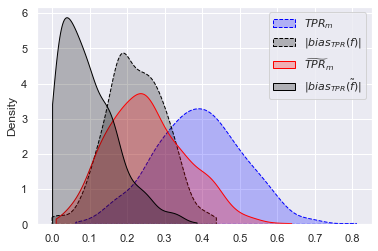

In [156]:
# Kde plots: Upper bound
sns.kdeplot(max_t_o,shade=True, cut = 0, label = '$TPR_{m}$',linestyle='--', color = 'blue')
sns.kdeplot(np.array(np.abs(bias_t_o)), shade = True, cut=0, label = r'$|bias_{TPR}(f)|$', color = 'black', linestyle='--')
sns.kdeplot(max_t_n,shade=True, cut = 0,label = r'$\widetilde{TPR}_{m}$', color = 'red')
sns.kdeplot(np.array(np.abs(bias_t_n)),shade=True, cut = 0, label = r'$|bias_{TPR}(\tilde{f})|$',color='black')
plt.legend()
plt.savefig('Figures/Exp3/real_data_tpr_control.png',bbox_inches="tight")

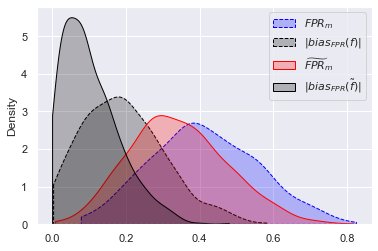

In [157]:
# Kde plots: Upper bound
sns.kdeplot(max_f_o,shade=True, cut = 0, label = '$FPR_{m}$',linestyle='--', color = 'blue')
sns.kdeplot(np.array(np.abs(bias_f_o)), shade = True, cut=0, label = r'$|bias_{FPR}(f)|$', color = 'black', linestyle='--')
sns.kdeplot(max_f_n,shade=True, cut = 0,label = r'$\widetilde{FPR}_{m}$', color = 'red')
sns.kdeplot(np.array(np.abs(bias_f_n)),shade=True, cut = 0, label = r'$|bias_{FPR}(\tilde{f})|$',color='black')
plt.legend()
plt.savefig('Figures/Exp3/real_data_fpr_control.png',bbox_inches="tight")

Improving bias estimation

In [74]:
# Calculating final validation accuracy and ROC curve
val = Dataset(d_xa_val)
val_dataloader = torch.utils.data.DataLoader(val, batch_size=len(d_xa_val))
device = torch.device("cpu")
model = model.eval()
with torch.no_grad():
    for val_input, val_label, val_remain in val_dataloader:
        val_label = val_label.to(device).float()
        mask = val_input['attention_mask'].to(device)
        input_id = val_input['input_ids'].squeeze(1).to(device)
        output = model(input_id, mask).reshape(1,-1)[0]

Optimal threshold =  0.03607214428857715


0.029315960912052116

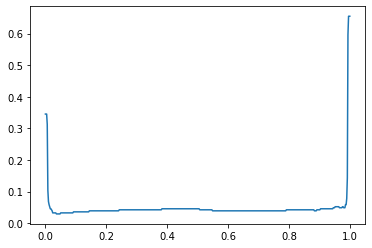

In [76]:
# Optimal Threshold for accuracy of a_hat
total_error = []
thresholds = np.linspace(0,1,500)
for t in thresholds:
    a_hat = output >= t
    a_hat = a_hat.numpy().astype('int')

    # Error of h(x) on this data
    incorrect = np.sum((d_xa_val['nationality'] != a_hat))
    error = (incorrect)/(d_xa_val.shape[0])
    total_error.append(error)

total_error = np.array(total_error)
opt_t = thresholds[np.argmin(total_error)]
print('Optimal threshold = ', opt_t)
# plt.plot(thresholds,total_error)
# plt.xlabel('Thresholds')
# plt.ylabel('Error')
plt.plot(thresholds,total_error)
np.min(total_error)

Improving bias estimation

In [77]:
def generate_estimates(t,output,d_xy_test):
    # Add a_hat column to data using opt_t
    a_hat = output >= t
    d_xy_test['a_hat'] = a_hat.numpy().astype('int')

    # Error of h(x) on this data
    incorrect = np.sum((d_xy_test['nationality'] != d_xy_test['a_hat']))
    error = (incorrect)/(d_xy_test.shape[0])
    #print('a_error = ', error)

    y1 = d_xy_test[d_xy_test['wage_eur'] == 1]
    incorrect = np.sum(y1['a_hat'] != y1['nationality'])/y1.shape[0]
    U1 = incorrect*(y1.shape[0]/d_xy_test.shape[0])
    y0 = d_xy_test[d_xy_test['wage_eur'] == 0]
    incorrect = np.sum(y0['a_hat'] != y0['nationality'])/y0.shape[0]
    U2 = incorrect*(y0.shape[0]/d_xy_test.shape[0])

    # Evaluate the equal oppurtunity violation using a_hat using threshold of 0.5 for f
    a1_y1 = d_xy_test[(d_xy_test['a_hat'] == 1) & (d_xy_test['wage_eur'] == 1)]
    a0_y1 = d_xy_test[(d_xy_test['a_hat'] == 0) & (d_xy_test['wage_eur'] == 1)]
    a1_y0 = d_xy_test[(d_xy_test['a_hat'] == 1) & (d_xy_test['wage_eur'] == 0)]
    a0_y0 = d_xy_test[(d_xy_test['a_hat'] == 0) & (d_xy_test['wage_eur'] == 0)]
    alpha_hat = np.sum((a1_y1['y_prob'] >= 0.5) == 1)/a1_y1.shape[0]
    beta_hat = np.sum((a0_y1['y_prob'] >= 0.5) == 1)/a0_y1.shape[0]
    tau_hat = np.sum((a1_y0['y_prob'] >= 0.5) == 1)/a1_y0.shape[0]
    phi_hat = np.sum((a0_y0['y_prob'] >= 0.5) == 1)/a0_y0.shape[0]
    bias_tpr_hat = np.abs(alpha_hat - beta_hat)
    bias_fpr_hat = np.abs(tau_hat - phi_hat)
    # k1 = 1 + (error/(2*s**2*r**2))*((2*r**4*s + 2*s**4*r - error*r**4 - error*s**4 + error*r**2*s**2)/(2*r*s - error*s - error*r))
    # print('Lower bound =', bias_tpr_hat)
    # print('Upper bound = ', bias_tpr_hat*k1)
    # print('bias_tpr_hat =', bias_tpr_hat)

    return bias_tpr_hat, bias_fpr_hat, error, U1, U2

In [111]:
# Will repeatedly split data into
# d_xy_train
# d_xy_test
# d_xy_tune
# Split data 
true_bias_tpr = []
true_bias_fpr = []
old_bias_tpr = []
old_bias_fpr = []
new_bias_tpr = []
new_bias_fpr = []
old_error = []
U1_old = []
U2_old = []
new_error_tpr = []
new_error_fpr = []
new_bias_tpr = []
new_bias_fpr = []
U1_new_tpr = []
U2_new_tpr = []
U1_new_fpr = []
U2_new_fpr = []
thresholds = np.linspace(0,1,101)

for i in range(50):
    d_xy_train, d_xy_remain = train_test_split(d_remain, train_size = 0.8, stratify=d_remain['group'])
    d_xy_test, d_xay = train_test_split(d_xy_remain, train_size = 0.5, stratify=d_xy_remain['group'])

    # Create Classifier
    clf = RandomForestClassifier(n_estimators=50)

    # Split data into features and labels
    x_train = d_xy_train[['age','overall']]
    y_train = d_xy_train['wage_eur']
    x_test = d_xy_test[['age','overall']]
    y_test = d_xy_test['wage_eur']

    # Fit classifier
    clf.fit(x_train.to_numpy(),y_train)

    # Model Accuracy:
    print("Accuracy:",metrics.accuracy_score(y_test, clf.predict(x_test.to_numpy())))

    # Evaluate probabilities on test set
    y_prob = clf.predict_proba(x_test.to_numpy())
    
    # Add y_prob to data
    d_xy_test['y_prob'] = y_prob[:,1]

    # Calculating hat_a
    xy_test = Dataset(d_xy_test)
    xy_test_dataloader = torch.utils.data.DataLoader(xy_test, batch_size=len(xy_test))
    device = torch.device("cpu")
    model = model.eval()
    with torch.no_grad():
        for xy_test_input, xy_test_label, xy_test_remain in xy_test_dataloader:
            xy_test_label = xy_test_label.to(device).float()
            mask = xy_test_input['attention_mask'].to(device)
            input_id = xy_test_input['input_ids'].squeeze(1).to(device)
            output = model(input_id, mask).reshape(1,-1)[0]
    
    # Evaluate true bias
    a1_y1 = d_xy_test[(d_xy_test['nationality'] == 1) & (d_xy_test['wage_eur'] == 1)]
    a0_y1 = d_xy_test[(d_xy_test['nationality'] == 0) & (d_xy_test['wage_eur'] == 1)]
    a1_y0 = d_xy_test[(d_xy_test['nationality'] == 1) & (d_xy_test['wage_eur'] == 0)]
    a0_y0 = d_xy_test[(d_xy_test['nationality'] == 0) & (d_xy_test['wage_eur'] == 0)]
    alpha = np.sum((a1_y1['y_prob'] >= 0.5) == 1)/a1_y1.shape[0]
    beta = np.sum((a0_y1['y_prob'] >= 0.5) == 1)/a0_y1.shape[0]
    tau = np.sum((a1_y0['y_prob'] >= 0.5) == 1)/a1_y0.shape[0]
    phi = np.sum((a0_y0['y_prob'] >= 0.5) == 1)/a0_y0.shape[0]
    true_bias_tpr.append(np.abs(alpha - beta))
    true_bias_fpr.append(np.abs(tau - phi))
    # print('bias_tpr =', bias_tpr)

    # Use generate estimates function
    bias_tpr_hat_o, bias_fpr_hat_o, a_error, error_1, error_2 = generate_estimates(opt_t,output,d_xy_test)
    old_bias_tpr.append(bias_tpr_hat_o)
    old_bias_fpr.append(bias_fpr_hat_o)
    old_error.append(a_error)
    U1_old.append(error_1)
    U2_old.append(error_2)

    #### Tuning
    # Tune h(x) on common data 
    d_tune = Dataset(d_xay)
    d_tune_dataloader = torch.utils.data.DataLoader(d_tune, batch_size=len(d_xay))
    device = torch.device("cpu")
    model = model.eval()
    with torch.no_grad():
        for tune_input, tune_label, tune_remain in d_tune_dataloader:
            tune_label = tune_label.to(device).float()
            mask = tune_input['attention_mask'].to(device)
            input_id = tune_input['input_ids'].squeeze(1).to(device)
            tune_output = model(input_id, mask).reshape(1,-1)[0]

    # Processing data for later calculations
    tune_label = np.array(tune_label)
    tune_output = np.array(tune_output)
    tune_remain = np.array(tune_remain)
    tune_Y = []
    for i in range(len(tune_remain)):
        tune_Y.append(tune_remain[i][2])
    tune_Y = np.array(tune_Y)
    
    # Concatenate y, a_label_test, outcomes_test to understand the error rates as function of threshold 
    Y_A_Ap = np.hstack((tune_Y.reshape(-1,1),tune_label.reshape(-1,1),tune_output.reshape(-1,1)))
    Y_A = Y_A_Ap[:,:2]

    # Look at error rates as a function of thresholds
    g1 = []
    g2 = []
    d1 = []
    d2 = []
    for thresh in thresholds:
        A_pred = (Y_A_Ap[:,2] >= thresh)
        # g1
        indices = np.where(np.sum(Y_A == [1,0],axis = 1) == 2)
        A_labels = A_pred[indices]
        g1.append(np.sum(Y_A[:,1][indices] != A_labels)/(np.size(indices)))
        # g2
        indices = np.where(np.sum(Y_A == [1,1],axis = 1) == 2)
        A_labels = A_pred[indices]
        g2.append(np.sum(Y_A[:,1][indices] != A_labels)/(np.size(indices)))
        # h1
        indices = np.where(np.sum(Y_A == [0,0],axis = 1) == 2)
        A_labels = A_pred[indices]
        d1.append(np.sum(Y_A[:,1][indices] != A_labels)/(np.size(indices)))
        # h2
        indices = np.where(np.sum(Y_A == [0,1],axis = 1) == 2)
        A_labels = A_pred[indices]
        d2.append(np.sum(Y_A[:,1][indices] != A_labels)/(np.size(indices)))

    g1 = np.array(g1)
    g2 = np.array(g2)
    d1 = np.array(d1)
    d2 = np.array(d2)

    # Calculating gamma_1 and gamma_2
    gamma_1 = np.abs(1-g1-g2)/(((s/r)*(1-g1)+g2)*((r/s)*(1-g2)+g1))

    # Calculating gamma_1 and gamma_2
    gamma_2 = np.abs(1-d1-d2)/(((v/w)*(1-d1)+d2)*((w/v)*(1-d2)+d1))

    # Optimal threshold for gamma_1 maximization or gamma_2 maximization
    nan_ind1 = np.where(np.isnan(gamma_1) == True)[0]
    nan_ind2 = np.where(np.isnan(gamma_2) == True)[0]
    nan_ind = np.concatenate([nan_ind1, nan_ind2[~np.isin(nan_ind2,nan_ind1)]])

    # Remove nan
    gamma_1 = np.delete(gamma_1, nan_ind)
    gamma_2 = np.delete(gamma_2, nan_ind)
    g1 = np.delete(g1,nan_ind)
    g2 = np.delete(g2,nan_ind)
    h1 = np.delete(d1,nan_ind)
    h2 = np.delete(d2,nan_ind)
    thresholds = np.delete(thresholds,nan_ind)

    # Optimal Thresholds for various tasks
    opt_t_gamma_1 = thresholds[np.argmax(gamma_1)]
    opt_t_gamma_2 = thresholds[np.argmax(gamma_2)]
    # print(opt_t_gamma_1)
    # print("Optimal Threshold for max gamma_1",opt_t_gamma_1)
    # print("Optimal Threshold for max gamma_2",opt_t_gamma_2)

    # Add a_hat column to data using opt_t_gamma_1
    bias_tpr_hat_n, bias_fpr_hat_n, a_error, error_1, error_2 = generate_estimates(opt_t_gamma_1,output,d_xy_test)
    new_bias_tpr.append(bias_tpr_hat_n)
    new_error_tpr.append(a_error)
    U1_new_tpr.append(error_1)
    U2_new_tpr.append(error_2)

    # Add a_hat column to data using opt_t_gamma_1
    bias_tpr_hat_n, bias_fpr_hat_n, a_error, error_1, error_2 = generate_estimates(opt_t_gamma_2,output,d_xy_test)
    new_bias_fpr.append(bias_fpr_hat_n)
    new_error_fpr.append(a_error)
    U1_new_fpr.append(error_1)
    U2_new_fpr.append(error_2)


Accuracy: 0.7843137254901961


/var/folders/ww/dc85f0d57734qs_yc7sf14t40000gn/T/ipykernel_43605/3349293721.py:139: RuntimeWarning: invalid value encountered in true_divide
  gamma_1 = np.abs(1-g1-g2)/(((s/r)*(1-g1)+g2)*((r/s)*(1-g2)+g1))
/var/folders/ww/dc85f0d57734qs_yc7sf14t40000gn/T/ipykernel_43605/3349293721.py:142: RuntimeWarning: invalid value encountered in true_divide
  gamma_2 = np.abs(1-d1-d2)/(((v/w)*(1-d1)+d2)*((w/v)*(1-d2)+d1))


Accuracy: 0.8333333333333334
Accuracy: 0.8137254901960784
Accuracy: 0.8431372549019608
Accuracy: 0.7647058823529411
Accuracy: 0.8333333333333334
Accuracy: 0.8235294117647058
Accuracy: 0.8823529411764706
Accuracy: 0.7941176470588235
Accuracy: 0.8627450980392157
Accuracy: 0.8235294117647058
Accuracy: 0.7843137254901961
Accuracy: 0.7941176470588235
Accuracy: 0.8235294117647058
Accuracy: 0.8333333333333334
Accuracy: 0.8725490196078431
Accuracy: 0.7941176470588235
Accuracy: 0.8431372549019608
Accuracy: 0.8137254901960784
Accuracy: 0.8529411764705882
Accuracy: 0.803921568627451
Accuracy: 0.8431372549019608
Accuracy: 0.8235294117647058
Accuracy: 0.8627450980392157
Accuracy: 0.803921568627451
Accuracy: 0.8431372549019608
Accuracy: 0.8235294117647058
Accuracy: 0.8431372549019608
Accuracy: 0.8235294117647058
Accuracy: 0.8529411764705882
Accuracy: 0.8921568627450981
Accuracy: 0.8627450980392157
Accuracy: 0.8725490196078431
Accuracy: 0.8137254901960784
Accuracy: 0.7843137254901961
Accuracy: 0.7647

In [113]:
old_diff_tpr = np.abs(np.array(old_bias_tpr) - np.array(true_bias_tpr)).reshape(-1,1)
new_diff_tpr = np.abs(np.array(new_bias_tpr) - np.array(true_bias_tpr)).reshape(-1,1)
diffs_tpr = np.concatenate((old_diff_tpr,new_diff_tpr),axis = 1)

old_diff_fpr = np.abs(np.array(old_bias_fpr) - np.array(true_bias_fpr)).reshape(-1,1)
new_diff_fpr = np.abs(np.array(new_bias_fpr) - np.array(true_bias_fpr)).reshape(-1,1)
diffs_fpr = np.concatenate((old_diff_fpr,new_diff_fpr),axis = 1)

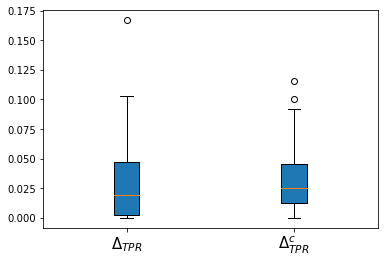

In [117]:
plt.boxplot(diffs_tpr,patch_artist=True)
plt.xticks([1, 2], [r'$\Delta_{TPR}$', r'$\Delta^c_{TPR}$'])
plt.xticks(fontsize=15 )
plt.savefig('better_estimation_final_tpr.png',bbox_inches="tight")

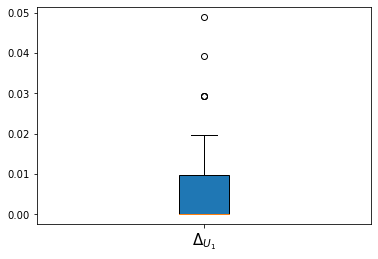

In [115]:
plt.boxplot(np.abs(np.array(U1_old) - np.array(U1_new_tpr)),patch_artist=True)
plt.xticks([1], [r'$\Delta_{U_1}$'])
plt.xticks(fontsize=15)
plt.savefig('deltaU.png',bbox_inches="tight")

In [689]:
# Computing max distributions
max_t_o = np.maximum(np.abs(u_bound_t_o),np.abs(l_bound_t_o))
max_t_n = np.maximum(np.abs(u_bound_t_n),np.abs(l_bound_t_n))
max_f_o = np.maximum(np.abs(u_bound_f_o),np.abs(l_bound_f_o))
max_f_n = np.maximum(np.abs(u_bound_f_n),np.abs(l_bound_f_n))

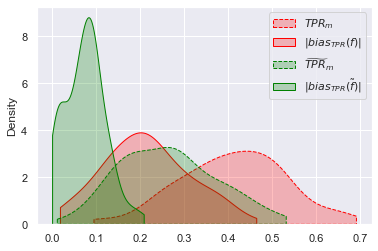

In [725]:
# Kde plots: Upper bound
sns.kdeplot(max_t_o, linestyle="--", shade = True, cut = 0, label = '$TPR_{m}$', color = 'red')
sns.kdeplot(np.array(np.abs(bias_tpr_before)),shade=True, cut = 0, label = r'$|bias_{TPR}(f)|$', color='red')
sns.kdeplot(max_t_n,shade=True, linestyle = '--', cut = 0,label = r'$\widetilde{TPR}_{m}$', color = 'green')
sns.kdeplot(np.array(np.abs(bias_tpr_after)),shade=True, cut = 0, label = r'$|bias_{TPR}(\tilde{f})|$',color='green')
plt.legend()
plt.savefig('real_data_tpr_bound.png',bbox_inches="tight")

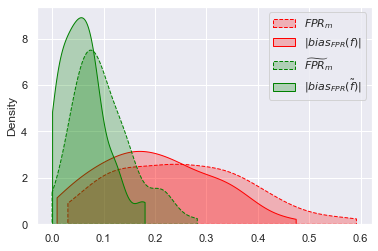

In [726]:
# Kde plots: Upper bound
sns.kdeplot(max_f_o, linestyle="--", shade = True, cut = 0, label = '$FPR_{m}$', color = 'red')
sns.kdeplot(np.array(np.abs(bias_fpr_before)),shade=True, cut = 0, label = r'$|bias_{FPR}(f)|$', color='red')
sns.kdeplot(max_f_n,shade=True, linestyle = '--', cut = 0,label = r'$\widetilde{FPR}_{m}$', color = 'green')
sns.kdeplot(np.array(np.abs(bias_fpr_after)),shade=True, cut = 0, label = r'$|bias_{FPR}(\tilde{f})|$',color='green')
plt.legend()
plt.savefig('real_data_fpr_bound.png',bbox_inches="tight")